In [128]:
import os
import numpy as np
from astropy.io import fits
from astropy.time import Time
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.table import Table
from astroquery.mast import Catalogs
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord, EarthLocation

In [129]:
tics = np.append(np.unique(log['TIC']), 333680372)
locations = {}

for tic in tics:
    s = Catalogs.query_object('TIC {0}'.format(tic), catalog='TIC')[0]
    locations[tic] = [s['ra'], s['dec']]

In [130]:
element = 'halpha'

if element == 'halpha':
    ordernum = 30
    fndir = 'halpha_orders/'
elif element == 'calcium':
    ordernum = 8
    fndir = 'calcium_triplet/'

In [131]:
wavetab = Table.read('thxe_lines_fibre_01_for_20180918.txt', format='ascii')
halphatab = wavetab[wavetab['order_number']==ordernum]

discrete = np.load('./201108/discrete_models.npy')
path = '/Users/arcticfox/Documents/youngStars/veloce/spectra/2011{0:02d}'

path_orders = '/Users/arcticfox/Documents/youngStars/veloce/spectra/{0}'.format(fndir)
orders = np.sort([os.path.join(path_orders, i) for i in os.listdir(path_orders)])

log = Table.read('/Users/arcticfox/Documents/youngStars/veloce/spectra/{0}_orders.tab'.format(element),
                 format='ascii')

Text(0, 0.5, 'wavelength [A]')

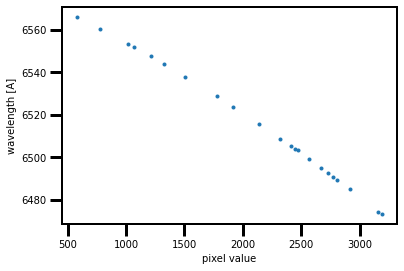

In [132]:
%matplotlib inline
plt.plot(halphatab['pixel'], halphatab['vac_ref_wl[A]'], '.')
plt.xlabel('pixel value')
plt.ylabel('wavelength [A]')

## Barycentric correction function

In [133]:
def get_barycorr(time, ra, dec):
    global LATITUDE, LONGITUDE, ALTITUDE

    aat = EarthLocation.from_geodetic(lat=LATITUDE, 
                                      lon=LONGITUDE,
                                      height=ALTITUDE)
    sc = SkyCoord(ra, dec, unit=(u.deg, u.deg))
    barycorr = sc.radial_velocity_correction('heliocentric',
                                             obstime=Time(time, format='mjd'), 
                                             location=aat)
    bc = barycorr.to(u.km/u.s) 
        
    return bc.value * u.km / u.s

## Dealing with x pixels

In [134]:
# interpolates xpixel value with wavelength
interp_wave = interp1d(halphatab['pixel'], halphatab['vac_ref_wl[A]'])

fitx = np.arange(300,4000,1)

newfitx = np.logspace(np.log10(halphatab['pixel'].min()+0.01), 
                      np.log10(halphatab['pixel'].max()-0.01), 5000, base=10.0)

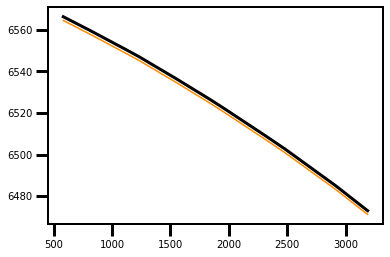

In [135]:
n = interp1d(halphatab['pixel'], halphatab['air_ref_wl[A]'])

plt.plot(newfitx, interp_wave(newfitx), 'k', lw=3)
plt.plot(newfitx, n(newfitx), 'darkorange')


In [136]:
print(interp_wave(newfitx)[-1]/10, n(newfitx)[-1]/10)

647.3002280051992 647.1214023929876


In [137]:
orders

array(['/Users/arcticfox/Documents/youngStars/veloce/spectra/halpha_orders/08nov30093_halpha.npy',
       '/Users/arcticfox/Documents/youngStars/veloce/spectra/halpha_orders/08nov30093_masked_halpha.npy',
       '/Users/arcticfox/Documents/youngStars/veloce/spectra/halpha_orders/08nov30094_halpha.npy',
       '/Users/arcticfox/Documents/youngStars/veloce/spectra/halpha_orders/08nov30094_masked_halpha.npy',
       '/Users/arcticfox/Documents/youngStars/veloce/spectra/halpha_orders/08nov30095_halpha.npy',
       '/Users/arcticfox/Documents/youngStars/veloce/spectra/halpha_orders/08nov30095_masked_halpha.npy',
       '/Users/arcticfox/Documents/youngStars/veloce/spectra/halpha_orders/08nov30096_halpha.npy',
       '/Users/arcticfox/Documents/youngStars/veloce/spectra/halpha_orders/08nov30096_masked_halpha.npy',
       '/Users/arcticfox/Documents/youngStars/veloce/spectra/halpha_orders/08nov30097_halpha.npy',
       '/Users/arcticfox/Documents/youngStars/veloce/spectra/halpha_orders/08nov3

In [138]:
wavelength_fns = []

for j in range(len(orders)):
    
    flux = np.load(orders[j])
    interp_flux = interp1d(fitx, flux)
    
    date_dir = int(orders[j].split('/')[-1].split('n')[0])
    
    filename = str(orders[j].split('/')[-1].split('.')[0].split('_')[0])
    
    row = [i for i in log['Filename'] if filename in i]
    if len(row) == 0:
        ra, dec = locations[tics[-1]][0], locations[tics[-1]][-1]
    else:
        arg = np.where(log['Filename']==row)[0]
        t = log['TIC'][arg].data[0]
        ra, dec = locations[t][0], locations[t][-1]

    
    fits_fn = np.sort([i for i in os.listdir(path.format(date_dir)) if 
                       filename in i and i.endswith('.fits')])[0]
    fits_fn = os.path.join(path.format(date_dir), fits_fn)
    
    hdu = fits.open(fits_fn)
    time = hdu[0].header['UTMJD']
    
    if j == 0:
        LATITUDE = hdu[0].header['LAT_OBS'] * u.deg
        LONGITUDE = hdu[0].header['LONG_OBS'] * u.deg
        ALTITUDE = hdu[0].header['ALT_OBS'] * u.m

    wavelength = interp_wave(newfitx) * u.AA
    speedlight = 2.998e8 * u.m / u.s
    barycorr = get_barycorr(time, ra, dec)
    dopshift = ((wavelength * barycorr) / speedlight).to(u.nm)
    wavelength = (wavelength - dopshift).to(u.nm)
        
    hdu.close()

    outname = os.path.join(path_orders, '{0}_with_wavelength.npy'.format(filename))
    np.save(outname,
            [wavelength*1.005, interp_flux(newfitx)])
    wavelength_fns.append(outname)

//anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:623: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
//anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [115]:
wavelength

<Quantity [656.62323621, 656.62267062, 656.62210484, ..., 647.30652852,
           647.30211299, 647.29769595] nm>

(0.7, 1.2)

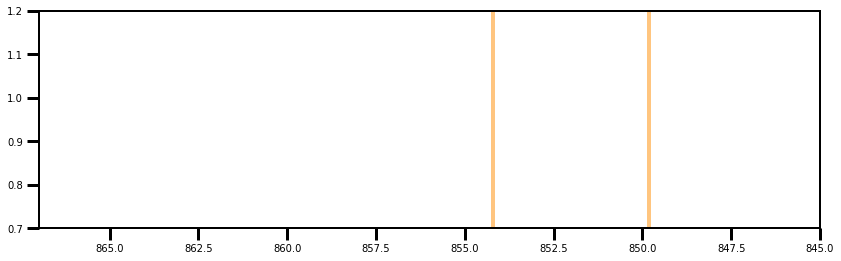

In [116]:
plt.figure(figsize=(14,4))
plt.plot(wavelength*1.005, interp_flux(newfitx), 'k')
plt.vlines(849.8, 0, 2, color='darkorange', alpha=0.5, lw=4)
plt.vlines(854.2, 0, 2, color='darkorange', alpha=0.5, lw=4)
plt.xlim(867, 845)
plt.ylim(0.7, 1.2)

(0.7, 4.0)

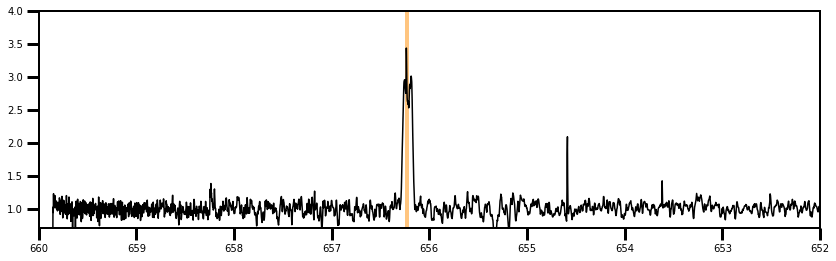

In [139]:
plt.figure(figsize=(14,4))
plt.plot(wavelength*1.005, interp_flux(newfitx), 'k')
plt.vlines(656.23, 0, 10, color='darkorange', alpha=0.5, lw=4)
#plt.vlines(854.2, 0, 2, color='darkorange', alpha=0.5, lw=4)
plt.xlim(660, 652)
plt.ylim(0.7, 4.0)

# Measure Equivalent Widths

In [140]:
master = Table.read('/Users/arcticfox/Documents/youngStars/veloce/master_log.tab',
                    format='ascii')
path = '/Users/arcticfox/Documents/youngStars/veloce/spectra/'
tab = Table.read(os.path.join(path, '{0}_orders.tab'.format(element)), format='ascii')

In [141]:
ew = {}
for t in tics:
    ew[t] = []

for i in range(len(wavelength_fns)):
    dat = np.load(wavelength_fns[i])
    
    wave = dat[0] +0.0#* 1.005
    
    if element == 'halpha':
        line_inds = np.where((wave >= 656.05) & (wave <= 656.4))[0]
        continuum_inds = np.where( ( ( wave>=655.4) & (wave<=656.0)  ) |
                                   ( (wave>=656.45) & (wave<=656.85) ) )[0]
    elif element == 'calcium':
        line_inds = np.where((wave>=849.5) & (wave<=850.3))[0]
        continuum_inds = np.where( ( (wave>=848.4) & (wave<=849.3) ) |
                                   ( (wave>=850.5) & (wave<=852) ) )[0]
    
    string = wavelength_fns[i].split('/')[-1]
    date = string.split('n')[0]
    file = string.split('_')[0]
    
    line_area = np.abs(np.trapz(dat[1][line_inds], x=dat[0][line_inds]))
    continuum = np.nanmedian(dat[1][continuum_inds])
    
    frac = (dat[1][line_inds][1:]-continuum)/continuum
    dx = np.diff(dat[0][line_inds])
    summed_ew = (np.nansum(frac * dx)*u.nm).to(u.AA)
    
    if int(date) < 20:
        ew[333680372].append(summed_ew.value)
    else:
        fn = [i for i in tab['Filename'] if file in i][0]
        tic = tab[tab['Filename']==fn]['TIC'].data[0]
        ew[tic].append(summed_ew.value)
    
    """
    plt.plot(wave, dat[1], 'k')
    plt.plot(wave[line_inds], dat[1][line_inds], c='darkorange')
    plt.plot(wave[continuum_inds], dat[1][continuum_inds], c='skyblue')
    plt.xlim(860,845)
    plt.ylim(0,4)
    plt.show()
    """

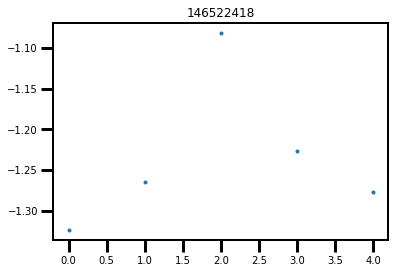

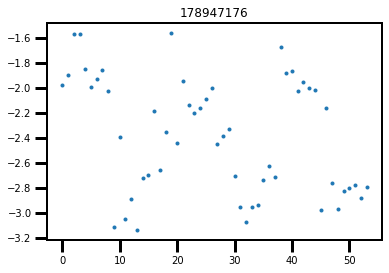

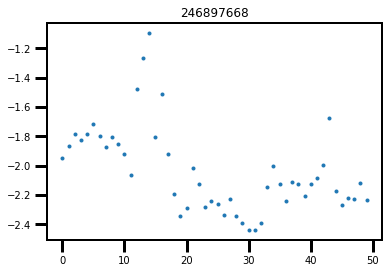

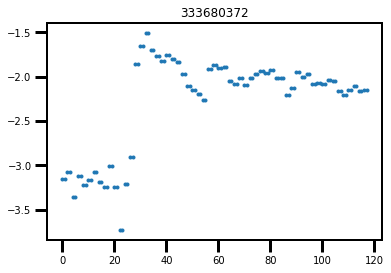

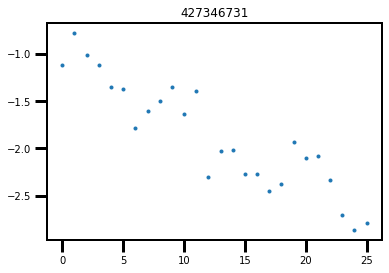

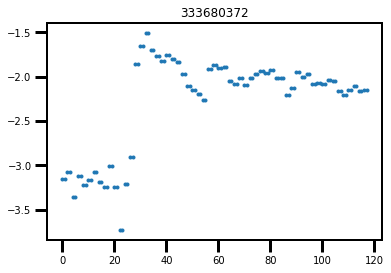

In [142]:
for t in tics:
    plt.title(t)
    plt.plot(ew[t], '.')
    plt.show()

In [143]:
for tic in tics:
    np.save(os.path.join(path, 'ew_{0}_{1}.npy'.format(element, tic)), ew[tic])